In [1]:
import torch
from torch_geometric.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

from gnn import GNN

import os
from tqdm import tqdm
import argparse
import time
import numpy as np
import random

torch.cuda.is_available()

True

### hard-coded arguments

explain GCN model

In [2]:
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.checkpoint_dir = "checkpoint"
args.device = 0

In [3]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [4]:
shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}


## load data

In [5]:
import pandas as pd

In [6]:
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)

In [7]:
## collate data as a list

valid_data_list = []
y_true = []
for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

    # collate data
    for i in range(batch.y.shape[0]):
        valid_data_list.append(batch[i])

    # collate label
    label = batch.y.detach().cpu().numpy()
    y_true.extend(label)

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [00:55<00:00, 26.82it/s]


In [14]:
validDF = pd.DataFrame(y_true, columns=["y_true"])
validDF["data"] = valid_data_list

validDF

,y_true,data
0,4.870838,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
1,5.322547,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
2,5.240913,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
3,5.227307,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
4,4.868117,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
...,...,...
380665,5.347037,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
380666,5.809631,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
380667,5.064039,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."
380668,5.336153,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,..."


### load model

In [9]:
from gnn import GNN

In [10]:
"""
Get intermediate graph embeddings and visualise
"""
def getPred(model):
    y_pred = []
    for step, batch in enumerate(tqdm(valid_loader, desc="Iteration")):

        # put batch to cuda
        batch = batch.to(device)

        # collate prediction
        with torch.no_grad():
            pred = model(batch).view(-1,)    
            pred_np = pred.detach().cpu().numpy()
            y_pred.extend(pred_np)

    return y_pred

In [20]:
# (name, model, virtual node)
modelNames = [
    ("gcn", "gcn", False),
    ("gcn-virtual", "gcn", True), 
    ("gin", "gin", False), 
    ("gin-virtual", "gin", True), 
#     "mlp-fingerprint"
]

for modelName, gnn_type, virtual_node in modelNames:
    """
    LOAD Checkpoint data
    """
    filename = os.path.join(args.checkpoint_dir, "models", modelName, "checkpoint", 'checkpoint.pt')
    checkpoint = torch.load(filename)

    # load model
    model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()    
    
    # get prediction
    y_pred = getPred(model)
    
    # append
    validDF["{}_y_pred".format(modelName)] = y_pred

Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [01:34<00:00, 15.68it/s]


In [21]:
validDF

,y_true,data,gcn_y_pred,gcn-virtual_y_pred,gin_y_pred,gin-virtual_y_pred
0,4.870838,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.834198,4.948096,4.813580,4.832635
1,5.322547,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.402326,5.312970,5.301021,5.351560
2,5.240913,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.100242,5.109992,5.094769,5.050711
3,5.227307,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.172869,5.170673,5.138475,5.112179
4,4.868117,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.870536,4.910818,4.888057,5.013203
...,...,...,...,...,...,...
380665,5.347037,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.376453,5.427576,5.487772,5.436855
380666,5.809631,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.469414,5.497242,5.569160,5.557595
380667,5.064039,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.304187,5.472321,5.459343,5.333095
380668,5.336153,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.334840,5.472387,5.457138,5.328713


In [32]:
validDF["pred_std"] = validDF[['gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred']].std(axis=1)
validDF["pred_mean"] = validDF[['gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred']].mean(axis=1)
validDF["pred_error"] = validDF["pred_mean"] - validDF["y_true"]

validDF.sort_values("pred_std", ascending=False)

,y_true,data,gcn_y_pred,gcn-virtual_y_pred,gin_y_pred,gin-virtual_y_pred,pred_std,pred_mean,pred_error
365837,11.915866,"[(edge_attr, []), (edge_index, [tensor([], dty...",16.618021,0.000000,5.149832,13.452437,7.605486,8.805073,-3.110793
357556,11.915866,"[(edge_attr, []), (edge_index, [tensor([], dty...",16.618021,0.000000,5.149832,13.452437,7.605486,8.805073,-3.110793
351474,9.627388,"[(edge_attr, []), (edge_index, [tensor([], dty...",16.151428,0.000000,5.149833,12.661222,7.287738,8.490621,-1.136767
348622,9.627388,"[(edge_attr, []), (edge_index, [tensor([], dty...",16.151428,0.000000,5.149833,12.661222,7.287738,8.490621,-1.136767
349364,9.627388,"[(edge_attr, []), (edge_index, [tensor([], dty...",16.151428,0.000000,5.149833,12.661222,7.287738,8.490621,-1.136767
...,...,...,...,...,...,...,...,...,...
195433,5.956572,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.939503,5.940428,5.939417,5.937310,0.001318,5.939165,-0.017407
6025,5.537517,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.470195,5.468610,5.467295,5.468875,0.001189,5.468744,-0.068773
175736,5.630035,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",5.668712,5.669643,5.667079,5.667702,0.001128,5.668284,0.038249
224501,5.989226,"[(edge_attr, [tensor([1, 0, 0]), tensor([1, 0,...",6.008356,6.006361,6.007082,6.007236,0.000825,6.007259,0.018033


<AxesSubplot:xlabel='pred_std', ylabel='pred_error'>

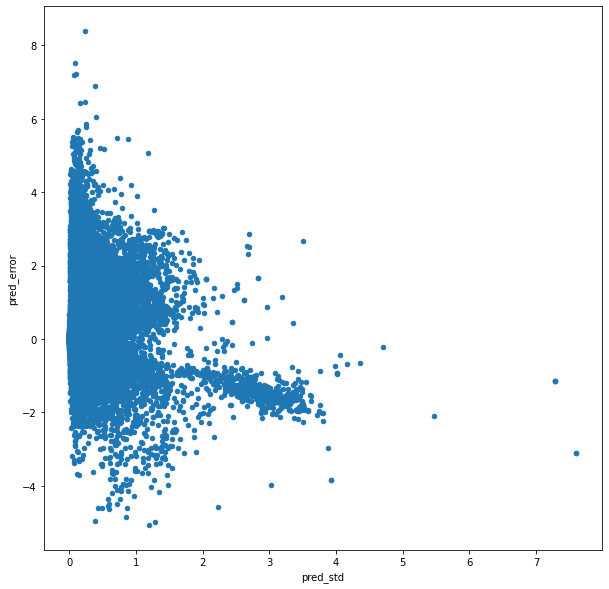

In [40]:
validDF.plot.scatter("pred_std", "pred_error", figsize=(10, 10))

## check how much model agrees with each other

In [52]:
validDF[['gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred']].corr()

,gcn_y_pred,gcn-virtual_y_pred,gin_y_pred,gin-virtual_y_pred
gcn_y_pred,1.000000,0.969842,0.988533,0.982371
gcn-virtual_y_pred,0.969842,1.000000,0.972350,0.972769
gin_y_pred,0.988533,0.972350,1.000000,0.985529
gin-virtual_y_pred,0.982371,0.972769,0.985529,1.000000


## try prediction with ensemble

In [41]:
evaluator = PCQM4MEvaluator()

In [53]:
validDF["pred_mean"] = validDF[['gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred']].mean(axis=1)
validDF["pred_median"] = validDF[['gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred']].median(axis=1)
modelTests = [
    'gcn_y_pred', 'gcn-virtual_y_pred', 'gin_y_pred', 'gin-virtual_y_pred', 'pred_mean', 'pred_median'
]

validDF.sort_values("pred_error", ascending=False)

,y_true,data,gcn_y_pred,gcn-virtual_y_pred,gin_y_pred,gin-virtual_y_pred,pred_std,pred_mean,pred_error,pred_median
147501,1.137436,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",9.422865,9.388668,9.887442,9.389325,0.244101,9.522075,8.384639,9.406095
110651,1.194580,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.634330,8.784916,8.790412,8.662187,0.081316,8.717961,7.523381,8.723551
77930,1.346964,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.696847,8.588414,8.508993,8.483533,0.095963,8.569447,7.222483,8.548704
212808,0.715659,"[(edge_attr, [tensor([0, 0, 1]), tensor([0, 0,...",8.001800,7.888706,7.911980,7.841836,0.067147,7.911080,7.195421,7.900343
196560,0.936072,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",7.819855,7.943001,7.313063,8.261024,0.394042,7.834236,6.898164,7.881428
...,...,...,...,...,...,...,...,...,...,...
199211,9.181121,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.176153,4.063507,4.560960,5.375330,0.593740,4.543988,-4.637133,4.368556
79077,9.028738,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",3.896740,3.319069,5.344320,4.224969,0.852064,4.196275,-4.832464,4.060855
161122,9.303573,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",3.943075,4.143552,4.497757,4.831897,0.392513,4.354070,-4.949502,4.320655
131055,9.257313,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.856483,2.643528,3.999573,5.636870,1.281931,4.284114,-4.973199,4.428028


In [54]:
maes = []
for modelName in modelTests:
    input_dict = {
        "y_true": torch.tensor(validDF["y_true"]), 
        "y_pred": torch.tensor(validDF[modelName])
    }
    mae = evaluator.eval(input_dict)["mae"]
    maes.append([modelName, mae])
    
maes

[['gcn_y_pred', 0.18449251568941846],
 ['gcn-virtual_y_pred', 0.17021231804729356],
 ['gin_y_pred', 0.1667899609236025],
 ['gin-virtual_y_pred', 0.15115169118633318],
 ['pred_mean', 0.15189750031559424],
 ['pred_median', 0.14960951796322877]]

In [60]:
validDF["pred_error_abs"] = abs(validDF["pred_error"])

sortDF = validDF.sort_values(["pred_error_abs", "pred_std"], ascending=False).reset_index()
sortDF

,index,y_true,data,gcn_y_pred,gcn-virtual_y_pred,gin_y_pred,gin-virtual_y_pred,pred_std,pred_mean,pred_error,pred_median,pred_error_abs
0,147501,1.137436,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",9.422865,9.388668,9.887442,9.389325,0.244101,9.522075,8.384639e+00,9.406095,8.384639e+00
1,110651,1.194580,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.634330,8.784916,8.790412,8.662187,0.081316,8.717961,7.523381e+00,8.723551,7.523381e+00
2,77930,1.346964,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.696847,8.588414,8.508993,8.483533,0.095963,8.569447,7.222483e+00,8.548704,7.222483e+00
3,212808,0.715659,"[(edge_attr, [tensor([0, 0, 1]), tensor([0, 0,...",8.001800,7.888706,7.911980,7.841836,0.067147,7.911080,7.195421e+00,7.900343,7.195421e+00
4,196560,0.936072,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",7.819855,7.943001,7.313063,8.261024,0.394042,7.834236,6.898164e+00,7.881428,6.898164e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
380665,871,4.574234,"[(edge_attr, [tensor([1, 0, 1]), tensor([1, 0,...",4.649848,4.556215,4.565728,4.525149,0.053304,4.574235,1.192093e-06,4.560972,1.192093e-06
380666,126411,4.119804,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",4.054028,4.151209,4.133113,4.140861,0.044472,4.119803,-1.072884e-06,4.136987,1.072884e-06
380667,29141,8.400154,"[(edge_attr, [tensor([0, 0, 0]), tensor([0, 0,...",8.556789,8.452044,8.203618,8.388166,0.148321,8.400155,4.768372e-07,8.420105,4.768372e-07
380668,15842,5.031385,"[(edge_attr, [tensor([1, 0, 0]), tensor([1, 0,...",5.175735,5.110727,4.961976,4.877102,0.136324,5.031385,1.192093e-07,5.036352,1.192093e-07


In [63]:
import networkx as nx
import matplotlib.pyplot as plt

def plotGraph(data, y_pred, y_true, ax, printnodelabel=False, printedgelabel=False):

    edges = data.edge_index.T.tolist()
    edges = np.array(edges)
    edges = [(x[0][0], x[0][1], {"feat": str(x[1])}) for x in list(zip(edges.tolist(), data.edge_attr.tolist()))]
    nodes = [(x[0], {"feat": str(x[1])}) for x in enumerate(data.x.tolist())]

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    nodelabels = nx.get_node_attributes(G, 'feat') 
    edgelabels = nx.get_edge_attributes(G, "feat")

    pos = nx.spring_layout(G)
    ax.set_title("pred={:.2f}, true={:.2f}".format(y_pred, y_true))
    if printnodelabel:
        nx.draw(G, pos, labels=nodelabels, ax=ax, node_size=40)
    else:
        nx.draw(G, pos, ax=ax, node_size=40)
        
    if printedgelabel:
        nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=edgelabels)


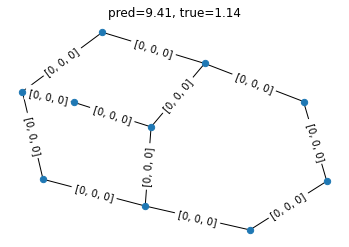

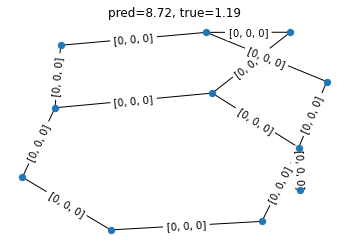

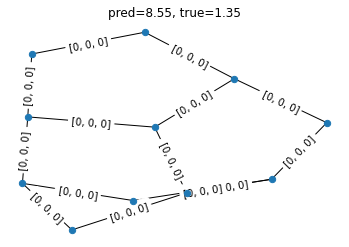

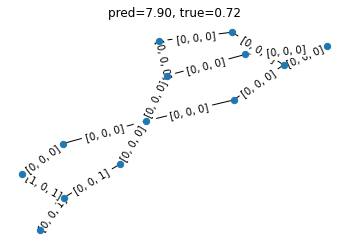

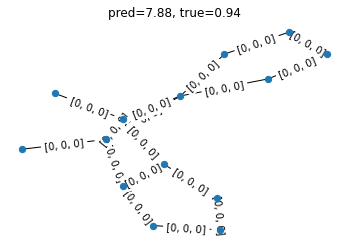

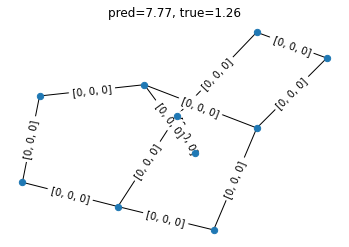

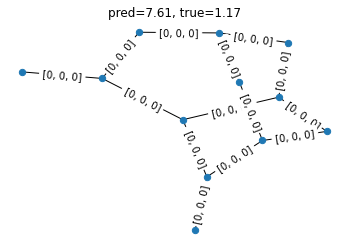

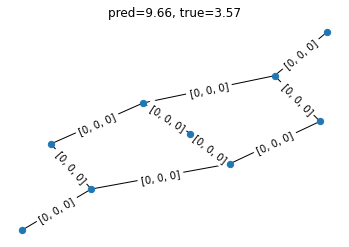

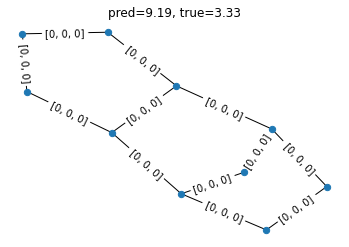

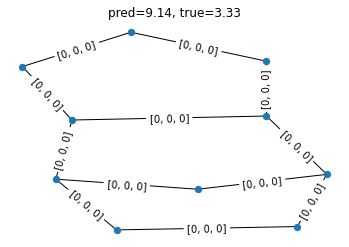

In [68]:
for _, row in sortDF.iloc[:10].iterrows():

    data = row["data"]
    y_pred = row["pred_median"]
    y_true = row["y_true"]

    fig, ax = plt.subplots()
    plotGraph(data, y_pred, y_true, ax, False, True)

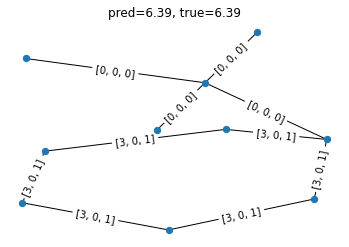

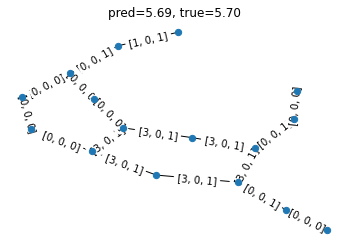

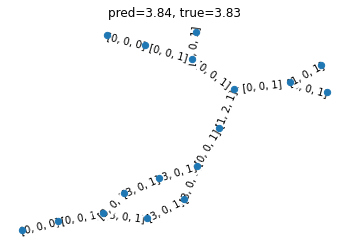

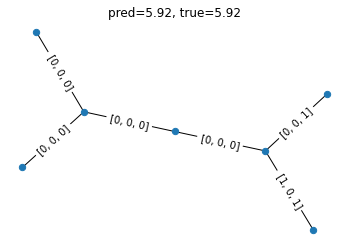

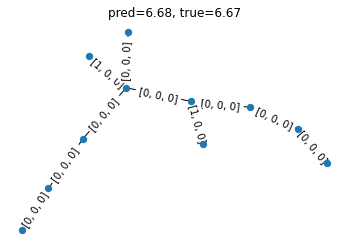

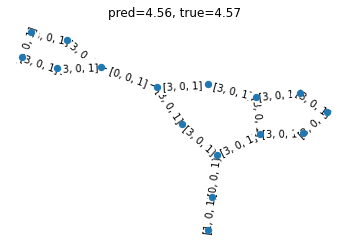

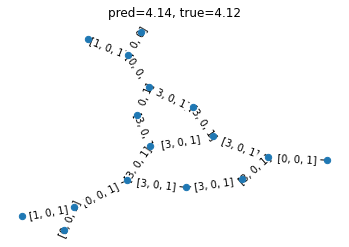

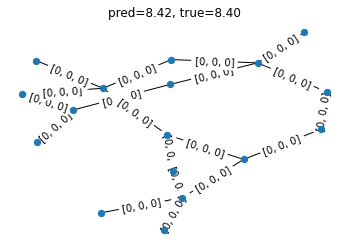

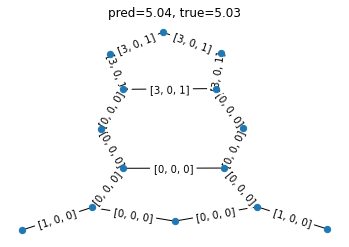

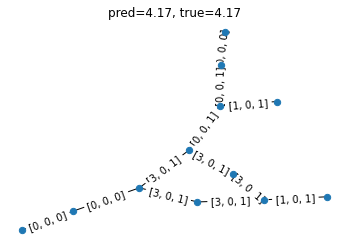

In [69]:
for _, row in sortDF.iloc[-10:].iterrows():

    data = row["data"]
    y_pred = row["pred_median"]
    y_true = row["y_true"]

    fig, ax = plt.subplots()
    plotGraph(data, y_pred, y_true, ax, False, True)

thoughts: can we use Integrated Gradient to explain which edge features affect prediction much (how about all [0, 0, 0])

https://colab.research.google.com/drive/1fLJbFPz0yMCQg81DdCP5I8jXw9LoggKO?usp=sharing